# LAB 5 - RANDOM FORESTS AND BOOSTING

This lab is comprised of 4 parts:

- 1. CART Baseline

- 2. Random Forests

- 3. Gradient Boosted Trees

- 4. Final Comparison

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ctr = pd.read_csv("CTR.csv")
ctr.info()
ctr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6057 entries, 0 to 6056
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CTR            6057 non-null   float64
 1   titleWords     6057 non-null   int64  
 2   adWords        6057 non-null   int64  
 3   depth          6057 non-null   int64  
 4   position       6057 non-null   int64  
 5   advCTR         6057 non-null   float64
 6   advCTRInPos    6057 non-null   float64
 7   queryCTR       6057 non-null   float64
 8   queryCTRInPos  6057 non-null   float64
 9   gender         6057 non-null   object 
 10  age            6057 non-null   object 
dtypes: float64(5), int64(4), object(2)
memory usage: 520.6+ KB


,CTR,titleWords,adWords,depth,position,advCTR,advCTRInPos,queryCTR,queryCTRInPos,gender,age
0,0.0000,8,17,1,1,0.0136,0.0153,0.0000,0.0000,male,0-12
1,0.0000,9,19,3,3,0.0199,0.0088,0.0394,0.0125,male,25-30
2,0.0675,6,30,2,1,0.0825,0.1002,0.0200,0.0256,female,13-18
3,0.0000,5,19,3,2,0.0116,0.0090,0.0042,0.0017,female,25-30
4,0.0000,10,22,1,1,0.0186,0.0284,0.0294,0.0431,female,0-12


## 1. CART BASELINE

### Decision Tree Regressor with CV

We will use a standard decision tree to establish a reference against which to evaluate the ensemble models

In [3]:
from sklearn.model_selection import train_test_split

y = ctr['CTR']
X = pd.get_dummies(ctr.drop(['CTR'], axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)
X_train.shape, X_test.shape

((4239, 18), (1818, 18))

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

grid_values = {'ccp_alpha': np.linspace(0, 0.001, 51)}

dtr = DecisionTreeRegressor(min_samples_leaf=5, min_samples_split=20, random_state=88)
dtr_cv = GridSearchCV(dtr, param_grid=grid_values, scoring='r2', cv=5, verbose=0)
dtr_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeRegressor(min_samples_leaf=5,
                                             min_samples_split=20,
                                             random_state=88),
             param_grid={'ccp_alpha': array([0.0e+00, 2.0e-05, 4.0e-05, 6.0e-05, 8.0e-05, 1.0e-04, 1.2e-04,
       1.4e-04, 1.6e-04, 1.8e-04, 2.0e-04, 2.2e-04, 2.4e-04, 2.6e-04,
       2.8e-04, 3.0e-04, 3.2e-04, 3.4e-04, 3.6e-04, 3.8e-04, 4.0e-04,
       4.2e-04, 4.4e-04, 4.6e-04, 4.8e-04, 5.0e-04, 5.2e-04, 5.4e-04,
       5.6e-04, 5.8e-04, 6.0e-04, 6.2e-04, 6.4e-04, 6.6e-04, 6.8e-04,
       7.0e-04, 7.2e-04, 7.4e-04, 7.6e-04, 7.8e-04, 8.0e-04, 8.2e-04,
       8.4e-04, 8.6e-04, 8.8e-04, 9.0e-04, 9.2e-04, 9.4e-04, 9.6e-04,
       9.8e-04, 1.0e-03])},
             scoring='r2')

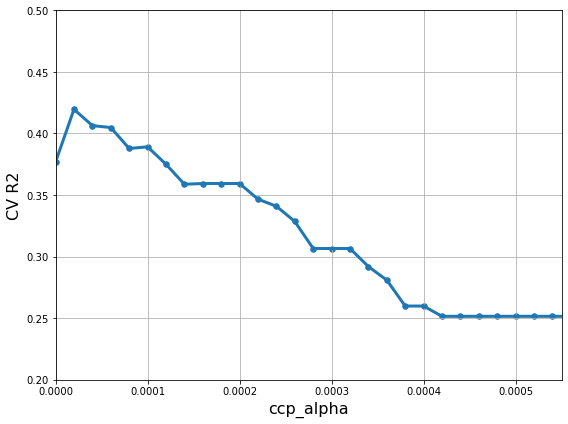

In [5]:
ccp_alpha = dtr_cv.cv_results_['param_ccp_alpha'].data
R2_scores = dtr_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('ccp_alpha', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(ccp_alpha, R2_scores, s=30)
plt.plot(ccp_alpha, R2_scores, linewidth=3)
plt.grid(True, which='both')
plt.xlim([0, 0.00055])
plt.ylim([0.2, 0.5])

plt.tight_layout()
plt.show()

In [6]:
print('Best ccp_alpha', dtr_cv.best_params_)

Best ccp_alpha {'ccp_alpha': 2e-05}


### Evaluation

In [7]:
def OSR2(model, X_test, y_test, y_train):
    
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

**Sidenote:** `sklearn` also has and R-squared implementation called `r2_score`, however, the computation of `SST` in its implementation does not use the mean of `y_train` as baseline; hence it is not advisable to use `r2_score` for Out-of-sample R-squared evaluation.

In [8]:
print('Cross-validated R2:', round(dtr_cv.best_score_, 5))
print('OSR2:', round(OSR2(dtr_cv, X_test, y_test, y_train), 5))

Cross-validated R2: 0.4196
OSR2: 0.43582


## 2. RANDOM FORESTS

### Random Forest Regressor

In [10]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=5, min_samples_leaf=5, n_estimators = 500, random_state=88, verbose=2)
rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.9s finished


RandomForestRegressor(max_features=5, min_samples_leaf=5, n_estimators=500,
                      random_state=88, verbose=2)

In [11]:
rf.verbose = False

print('OSR2:', round(OSR2(rf, X_test, y_test, y_train), 5))

OSR2: 0.56419


### Random Forest Regressor with CV

In [12]:
import time

grid_values = {'max_features': np.linspace(1,18,18, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88]} 

tic = time.time()

rf2 = RandomForestRegressor() 
rf_cv = GridSearchCV(rf2, param_grid=grid_values, scoring='r2', cv=5)
rf_cv.fit(X_train, y_train)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

time: 333.97 s


(0.3, 0.6)

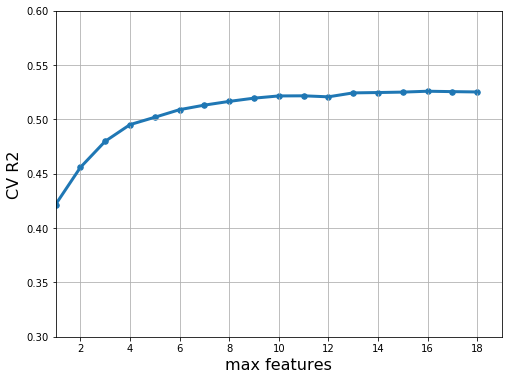

In [13]:
max_features = rf_cv.cv_results_['param_max_features'].data
R2_scores = rf_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('max features', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(max_features, R2_scores, s=30)
plt.plot(max_features, R2_scores, linewidth=3)
plt.grid(True, which='both')
plt.xlim([1, 19])
plt.ylim([0.3, 0.6])

In [14]:
print(rf_cv.best_params_)

{'max_features': 16, 'min_samples_leaf': 5, 'n_estimators': 500, 'random_state': 88}


In [15]:
print('Cross-validated R2:', round(rf_cv.best_score_, 5))
print('OSR2:', round(OSR2(rf_cv, X_test, y_test, y_train), 5))

Cross-validated R2: 0.52587
OSR2: 0.55579


### Feature Importance

In [16]:
pd.DataFrame({'Feature' : X_train.columns, 
              'Importance score': 100*rf_cv.best_estimator_.feature_importances_}).round(1)

,Feature,Importance score
0,titleWords,3.7
1,adWords,3.0
2,depth,1.6
3,position,0.3
4,advCTR,14.5
5,advCTRInPos,45.6
6,queryCTR,7.5
7,queryCTRInPos,21.1
8,gender_female,0.5
9,gender_male,0.4


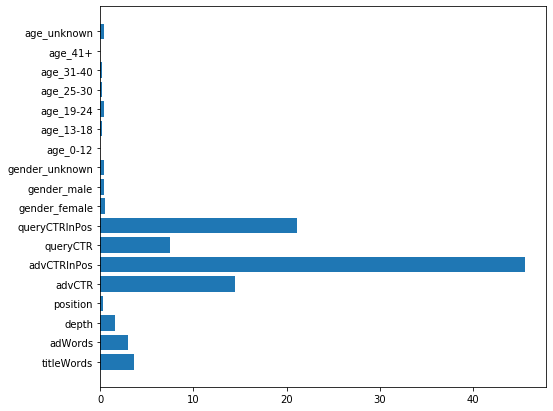

In [17]:
plt.figure(figsize=(8,7))
plt.barh(X_train.columns, 100*rf_cv.best_estimator_.feature_importances_)
plt.show()

## 3. GRADIENT BOOSTED TREES

### Gradient Boosting Regressor

Controlling tree size using `max_leaf_nodes` vs. `max_depth`: https://scikit-learn.org/stable/modules/ensemble.html#controlling-the-tree-size

We choose use `max_leaf_nodes` as our primary parameter to control the size of the tree: we set `max_depth` to a large value so that it does not interfere with the construction of the trees. 

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=2000, learning_rate= 0.001, max_leaf_nodes=3,
                                max_depth=100, min_samples_leaf=10, random_state=88, verbose=1) 
gbr.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.0060           15.82s
         2           0.0060           15.00s
         3           0.0060           14.28s
         4           0.0060           13.58s
         5           0.0060           13.20s
         6           0.0060           12.75s
         7           0.0060           12.48s
         8           0.0060           12.33s
         9           0.0060           12.11s
        10           0.0060           11.95s
        20           0.0059           11.06s
        30           0.0059           10.71s
        40           0.0059           10.56s
        50           0.0058           10.42s
        60           0.0058           10.30s
        70           0.0058           10.19s
        80           0.0057           10.08s
        90           0.0057           10.02s
       100           0.0057            9.95s
       200           0.0054            9.12s
       300           0.0051            8.58s
       40

GradientBoostingRegressor(learning_rate=0.001, max_depth=100, max_leaf_nodes=3,
                          min_samples_leaf=10, n_estimators=2000,
                          random_state=88, verbose=1)

In [19]:
print('OSR2:', round(OSR2(gbr, X_test, y_test, y_train), 5))

OSR2: 0.4388


### Gradient Boosting Regressor with CV

In [22]:
grid_values = {'n_estimators': np.logspace(9, 16, num=8, base=2, dtype='int32'),
               'learning_rate': [0.005],
               'max_leaf_nodes': np.linspace(2, 10, 9, dtype='int32'),
               'max_depth': [100],
               'min_samples_leaf': [10],
               'random_state': [88]}

tic = time.time()

gbr2 = GradientBoostingRegressor()
gbr_cv = GridSearchCV(gbr2, param_grid=grid_values, scoring='r2', cv=5)
gbr_cv.fit(X_train, y_train)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

time: 36560.15 s


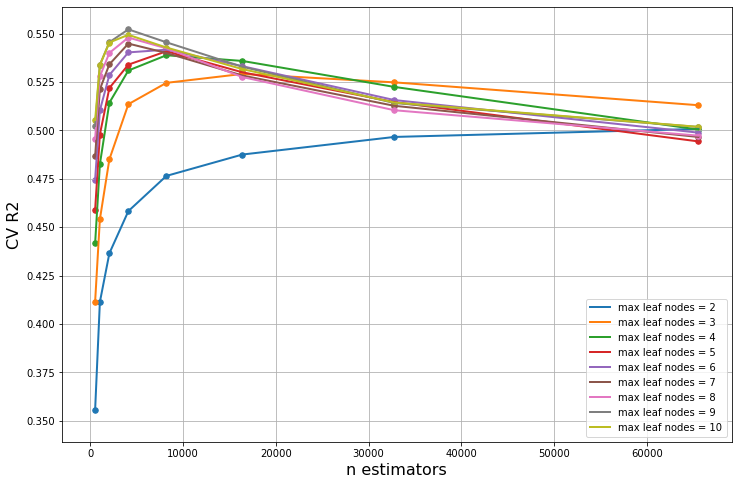

In [23]:
n_estimators = gbr_cv.cv_results_['param_n_estimators'].data
R2_scores = gbr_cv.cv_results_['mean_test_score']

plt.figure(figsize=(12, 8))
plt.xlabel('n estimators', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.grid(True, which='both')

N = len(grid_values['max_leaf_nodes'])
M = len(grid_values['n_estimators'])
for i in range(N):
    plt.scatter(n_estimators[(M*i):(M*i)+M], R2_scores[(M*i):(M*i)+M], s=30)
    plt.plot(n_estimators[(M*i):(M*i)+M], R2_scores[(M*i):(M*i)+M], linewidth=2,
             label='max leaf nodes = '+str(grid_values['max_leaf_nodes'][i]))
plt.legend(loc='lower right')
plt.show()

In [24]:
print(gbr_cv.best_params_)

{'learning_rate': 0.005, 'max_depth': 100, 'max_leaf_nodes': 9, 'min_samples_leaf': 10, 'n_estimators': 4096, 'random_state': 88}


In [35]:
print('Cross-validated R2:', round(gbr_cv.best_score_, 5))
print('OSR2:', round(OSR2(gbr_cv, X_test, y_test, y_train), 5))

Cross-validated R2: 0.55229
OSR2: 0.53877


In [27]:
pd.DataFrame({'Feature' : X_train.columns, 
              'Importance score': 100*gbr_cv.best_estimator_.feature_importances_}).round(1)

,Feature,Importance score
0,titleWords,1.8
1,adWords,2.8
2,depth,2.5
3,position,0.3
4,advCTR,13.0
5,advCTRInPos,51.2
6,queryCTR,5.5
7,queryCTRInPos,21.3
8,gender_female,0.5
9,gender_male,0.1


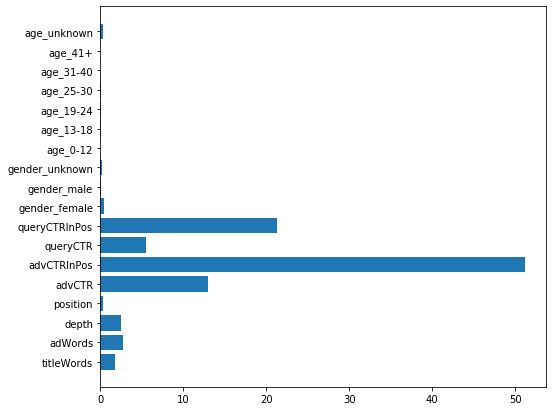

In [28]:
plt.figure(figsize=(8,7))
plt.barh(X_train.columns, 100*gbr_cv.best_estimator_.feature_importances_)
plt.show()

## 4. FINAL COMPARISON

In [29]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### Linear Regression Baseline

In [30]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X_train, y_train)

### Comparison Table

In [31]:
comparison_data = {'Linear Regression': ['{:.3f}'.format(OSR2(lr, X_test, y_test, y_train)),
                                         '{:.4f}'.format(mean_squared_error(y_test, lr.predict(X_test))),
                                         '{:.3f}'.format(mean_absolute_error(y_test, lr.predict(X_test)))],
                   'Decision Tree Regressor': ['{:.3f}'.format(OSR2(dtr_cv, X_test, y_test, y_train)),
                                               '{:.4f}'.format(mean_squared_error(y_test, dtr_cv.predict(X_test))),
                                               '{:.3f}'.format(mean_absolute_error(y_test, dtr_cv.predict(X_test)))],
                   'Random Forest': ['{:.3f}'.format(OSR2(rf_cv, X_test, y_test, y_train)),
                                     '{:.4f}'.format(mean_squared_error(y_test, rf_cv.predict(X_test))),
                                     '{:.3f}'.format(mean_absolute_error(y_test, rf_cv.predict(X_test)))], 
                   'Gradient Boosted Trees': ['{:.3f}'.format(OSR2(gbr_cv, X_test, y_test, y_train)),
                                              '{:.4f}'.format(mean_squared_error(y_test, gbr_cv.predict(X_test))),
                                              '{:.3f}'.format(mean_absolute_error(y_test, gbr_cv.predict(X_test)))]}

comparison_table = pd.DataFrame(data=comparison_data, index=['OSR2', 'Out-of-sample MSE', 'Out-of-sample MAE'])
comparison_table.style.set_properties(**{'font-size': '12pt',}).set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt')]}])

,Linear Regression,Decision Tree Regressor,Random Forest,Gradient Boosted Trees
OSR2,0.488,0.436,0.556,0.539
Out-of-sample MSE,0.0028,0.0030,0.0024,0.0025
Out-of-sample MAE,0.032,0.033,0.029,0.030


Let's look at MAE restricted to CTR above and below 10%

In [32]:
y_test_above = y_test[y_test >0.1]
X_test_above = X_test[y_test >0.1]

y_test_below = y_test[y_test <=0.1]
X_test_below = X_test[y_test <=0.1]

MAE_rf_above = mean_absolute_error(y_test_above, rf_cv.predict(X_test_above))
MAE_rf_below = mean_absolute_error(y_test_below, rf_cv.predict(X_test_below))

MAE_gbr_above = mean_absolute_error(y_test_above, gbr_cv.predict(X_test_above))
MAE_gbr_below = mean_absolute_error(y_test_below, gbr_cv.predict(X_test_below))

In [33]:
print('Random Forest Out-of-sample MAE for CTR above 10%:', round(MAE_rf_above, 3))
print('Random Forest Out-of-sample MAE for CTR below 10%:', round(MAE_rf_below, 3))

print('\nGradient Boosted Trees Out-of-sample MAE for CTR above 10%:', round(MAE_gbr_above, 3))
print('Gradient Boosted Trees Out-of-sample MAE for CTR below 10%:', round(MAE_gbr_below, 3))

Random Forest Out-of-sample MAE for CTR above 10%: 0.076
Random Forest Out-of-sample MAE for CTR below 10%: 0.021

Gradient Boosted Trees Out-of-sample MAE for CTR above 10%: 0.079
Gradient Boosted Trees Out-of-sample MAE for CTR below 10%: 0.021


## -------------------------------------------------------------------------------------------------------

## EXTRA

In [ ]:
# np.random.seed(66)

# train_idx = np.random.choice(len(ctr), size=int(len(ctr)*0.7), replace=False)
# ctr_train = ctr.iloc[train_idx]
# ctr_test = ctr.drop(index=train_idx)

# ctr_test.shape

In [ ]:
# ccp_alpha = dtr_cv.cv_results_['param_ccp_alpha'].data
# MSE_scores = dtr_cv.cv_results_['mean_test_neg_mean_squared_error']*(-1) # sklearn uses the negative of the loss as an objective function to maximize, rather than implementation a minimization scheme
# R2_scores = dtr_cv.cv_results_['mean_test_r2']

# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.xlabel('ccp_alpha', fontsize=16)
# plt.ylabel('CV R-squared', fontsize=16)
# plt.scatter(ccp_alpha, R2_scores, s=30)
# plt.plot(ccp_alpha, R2_scores, linewidth=3)
# plt.grid(True, which='both')
# plt.xlim([0, 0.00055])
# plt.ylim([0.2, 0.5])

# plt.subplot(1, 2, 2)
# plt.xlabel('ccp_alpha', fontsize=16)
# plt.ylabel('Mean Squared Error', fontsize=16)
# plt.scatter(ccp_alpha, MSE_scores, s=30)
# plt.plot(ccp_alpha, MSE_scores, linewidth=3)
# plt.grid(True, which='both')
# plt.xlim([0, 0.00055])
# plt.ylim([0.0025, 0.005])

# plt.tight_layout()
# plt.show()

### V1 (max_depth fixed)

In [ ]:
# grid_values = {'max_depth': [30],
#                'max_leaf_nodes': np.logspace(1, 10, 10, base=2, dtype='int32'), # BEFORE: np.logspace(1, 6, 6, base=2, dtype='int32'),
#                'min_samples_leaf': [10],
#                'n_estimators': [1000],
#                'learning_rate': [0.001],
#                'random_state': [88]} 

# tic = time.time()

# gbr = GradientBoostingRegressor()
# gbr_cv1 = GridSearchCV(gbr, param_grid=grid_values, scoring='r2', cv=5)
# gbr_cv1.fit(X_train, y_train)

# toc = time.time()
# print('time:', round(toc-tic, 2),'s')

### V2 (max_leaf_nodes fixed)

In [ ]:
# grid_values = {'max_depth': np.linspace(1, 20, 20, dtype='int32'), # BEFORE: np.linspace(1, 10, 10, dtype='int32'),
#                'max_leaf_nodes': [None],
#                'min_samples_leaf': [10],
#                'n_estimators': [1000],
#                'learning_rate': [0.001],
#                'random_state': [88]} 

# tic = time.time()

# gbr = GradientBoostingRegressor()
# gbr_cv2 = GridSearchCV(gbr, param_grid=grid_values, scoring='r2', cv=5)
# gbr_cv2.fit(X_train, y_train)

# toc = time.time()
# print('time:', round(toc-tic, 2),'s')

In [ ]:
# ## V1 plot
# max_leaf_nodes = gbr_cv1.cv_results_['param_max_leaf_nodes'].data
# R2_scores = gbr_cv1.cv_results_['mean_test_score']

# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.xlabel('max leaf nodes', fontsize=16)
# plt.ylabel('CV R2', fontsize=16)
# plt.scatter(max_leaf_nodes, R2_scores, s=30)
# plt.plot(max_leaf_nodes, R2_scores, linewidth=3)
# plt.grid(True, which='both')
# plt.xlim([0, 1025])
# plt.ylim([0.1, 0.6])
# plt.title('Max Depth = 30', fontsize=16)

# ## V2 plot
# max_depth = gbr_cv2.cv_results_['param_max_depth'].data
# R2_scores = gbr_cv2.cv_results_['mean_test_score']

# plt.subplot(1, 2, 2)
# plt.xlabel('max depth', fontsize=16)
# plt.ylabel('CV R2', fontsize=16)
# plt.scatter(max_depth, R2_scores, s=30)
# plt.plot(max_depth, R2_scores, linewidth=3)
# plt.title('Max Leaf Nodes = Unlimited', fontsize=16)
# plt.xlim([0, 21])
# plt.ylim([0.1, 0.6])
# plt.grid(True, which='both')
# plt.show()

# print(gbr_cv1.best_params_['max_leaf_nodes'], gbr_cv1.best_score_)
# print(gbr_cv2.best_params_['max_depth'], gbr_cv2.best_score_)

### Staged GBR (I & II)

In [ ]:
# grid_values = {'max_depth': [8],
#                'min_samples_leaf': [10],
#                'n_estimators': [2**15],
#                'learning_rate': [0.001], # (0.01)
#                'random_state': [88]} 

# tic = time.time()

# gbr = GradientBoostingRegressor()
# gbr_stage = GridSearchCV(gbr, param_grid=grid_values, scoring='r2', cv=5)
# gbr_stage.fit(X_train, y_train)

# toc = time.time()
# print('time:', round(toc-tic, 2),'s')

# print('CV R2:', round(gbr_stage.best_score_, 5))
# print('OSR2:', round(r2_score(y_test, gbr_stage.predict(X_test)), 5))

# test_score = np.zeros((grid_values['n_estimators'][0],), dtype=np.float64)
# R2 = np.zeros((grid_values['n_estimators'][0],), dtype=np.float64)
# for i, y_pred in enumerate(gbr_stage.best_estimator_.staged_predict(X_test)):
#     test_score[i] = gbr_stage.best_estimator_.loss_(y_test, y_pred)
#     R2[i] = r2_score(y_test, y_pred)
    
# fig = plt.figure(figsize=(10, 12))

# ax = fig.add_subplot(2, 1, 1)
# plt.title('Deviance')
# ax.plot(np.arange(grid_values['n_estimators'][0]) + 1, gbr_stage.best_estimator_.train_score_, 'b-',
#          label='Training Set Deviance')
# ax.plot(np.arange(grid_values['n_estimators'][0]) + 1, test_score, 'r-',
#          label='Test Set Deviance')
# ax.legend(loc='upper right')
# plt.xlabel('Boosting Iterations')
# plt.ylabel('Deviance')
# ax.set_xticks(np.arange(0, 35000, 2500))
# ax.set_yticks(np.arange(0, 0.006, 0.00025), minor=True)
# ax.grid(which='both')

# ax = fig.add_subplot(2, 1, 2)
# plt.title('R2')
# ax.plot(np.arange(grid_values['n_estimators'][0]) + 1, R2, 'r-',
#          label='Test Set R2')
# ax.legend(loc='upper right')
# plt.xlabel('Boosting Iterations')
# plt.ylabel('R2')
# ax.set_xticks(np.arange(0, 35000, 2500))
# ax.set_yticks(np.arange(0, 0.6, 0.025), minor=True)
# ax.grid(which='both')

# fig.tight_layout()
# plt.show()

In [ ]:
# grid_values = {'max_depth': [3, 4],
#                'min_samples_leaf': [10],
#                'n_estimators': np.linspace(500, 1000, 2, dtype='int32'),
#                'learning_rate': [0.001],
#                'random_state': [88]} 
# gbr2 = GradientBoostingRegressor()
# gbr_cv4 = GridSearchCV(gbr2, param_grid=grid_values, scoring='r2', cv=5)
# gbr_cv4.fit(X_train, y_train)
# gbr_cv4.cv_results_

# max_depth = [1, 1, 2, 2, 3, 3]
# N = len(grid_values['max_depth'])
# N = 3

# n_estimators = [500, 1000, 1500, 500, 1000, 1500, 500, 1000, 1500]
# M = len(grid_values['n_estimators'])
# M = 3

# for i in range(N):
#     print(n_estimators[(M*i):(M*i)+M])

# # max_depth = gbr_cv4.cv_results_['param_max_depth'].data
# n_estimators = gbr_cv4.cv_results_['param_n_estimators'].data
# R2_scores = rf_cv.cv_results_['mean_test_score']

# plt.figure(figsize=(8, 6))
# plt.xlabel('n estimators', fontsize=16)
# plt.ylabel('CV R2', fontsize=16)
# plt.grid(True, which='both')
# plt.xlim([0, 20000])
# plt.ylim([0.2, 0.6])

# N = len(grid_values['max_depth'])
# M = len(grid_values['n_estimators'])

# for i in range(N):
#     plt.scatter(n_estimators[(M*i):(M*i)+M], R2_scores[(M*i):(M*i)+M], s=30)
#     plt.plot(n_estimators[(M*i):(M*i)+M], R2_scores[(M*i):(M*i)+M], linewidth=3,
#              label='max depth = '+str(grid_values['max_depth'][i]))
# plt.legend(loc='lower right')
# plt.show()

In [ ]:
# print('Linear Regression OSR2:', round(r2_score(y_test, lr.predict(X_test)), 5))
# print('CART OSR2:', round(r2_score(y_test, dtr_cv.predict(X_test)), 5))
# print('Random Forest OSR2:', round(r2_score(y_test, rf_cv.predict(X_test)), 5))
# print('Gradient Boosted Trees OSR2:', round(r2_score(y_test, gbr_cv3.predict(X_test)), 5))

# print('\nLinear Regression Out-of-sample MSE:', round(mean_squared_error(y_test, lr.predict(X_test)), 5))
# print('Decision Tree Regressor Out-of-sample MSE:', round(mean_squared_error(y_test, dtr_cv.predict(X_test)), 5))
# print('Random Forest Out-of-sample MSE:', round(mean_squared_error(y_test, rf_cv.predict(X_test)), 5))
# print('Gradient Boosted Trees Out-of-sample MSE:', round(mean_squared_error(y_test, gbr_cv3.predict(X_test)), 5))

# print('\nLinear Regression Out-of-sample MAE:', round(mean_absolute_error(y_test, lr.predict(X_test)), 5))
# print('Decision Tree Regressor Out-of-sample MAE:', round(mean_absolute_error(y_test, dtr_cv.predict(X_test)), 5))
# print('Random Forest Out-of-sample MAE:', round(mean_absolute_error(y_test, rf_cv.predict(X_test)), 5))
# print('Gradient Boosted Trees Out-of-sample MAE:', round(mean_absolute_error(y_test, gbr_cv3.predict(X_test)), 5))